

# Environment Feature Ablation Study: RL Stock Trading

## Objective

This study aims to **quantify the importance of internal environment features** versus market features in a deep RL trading setup. We want to answer:
*“Which observation features actually help the RL agent generalize and perform?”*

## Experimental Setup

* **Environment:** Custom RL trading environment with *both market features* (price/volume/technical) and *internal features* (agent position, holding time, drawdown, etc).
* **Agent:** PPO (Proximal Policy Optimization)
* **Metrics:** Episode Sharpe ratio (main), with t-tests and Mann-Whitney tests for RL vs. random agent baseline.

### Feature Groups Ablated

* `all_features`: All market + internal features
* `market_only`: Only market-based features (no internal)
* `internal_only`: Only internal environment state features
* `no_<feature>`: All except one internal feature (drop-one-out)

### Walk-forward splits

* **Train/test:** Two non-overlapping 6-month test splits across different market periods
* **Repeat:** Each ablation/feature set is tested out-of-sample

## Analysis Procedure

1. **Train PPO agent** on each feature set, for each split
2. **Test RL vs random agent** for each configuration
3. **Collect metrics:** Sharpe, Sortino, Calmar, total reward, alpha, win rate, etc.
4. **Statistical tests:**

   * *Is RL agent Sharpe significantly better than random agent?*
5. **Aggregate:** Compare mean Sharpe per feature ablation and visualize.

## Key Results

| ablation               | mean\_sharpe\_rl | mean\_sharpe\_random | t\_pvalue | u\_pvalue | RL>Random |
| ---------------------- | :--------------: | :------------------: | :-------: | :-------: | :-------: |
| internal\_only         |       0.09       |         -0.04        |    0.04   |    0.03   |    True   |
| no\_cumulative\_reward |       0.08       |         -0.04        |    0.06   |    0.04   |    True   |
| no\_entry\_price       |       0.08       |         -0.05        |    0.05   |    0.04   |    True   |
| no\_unrealized\_pnl    |       0.07       |         -0.04        |    0.07   |    0.06   |    True   |
| no\_drawdown           |       0.06       |         -0.04        |    0.13   |    0.12   |    True   |
| no\_pct\_time          |       0.06       |         -0.04        |    0.13   |    0.12   |    True   |
| market\_only           |       -0.03      |         -0.03        |    0.43   |    0.41   |   False   |
| all\_features          |       0.02       |         -0.03        |    0.21   |    0.18   |   False   |

> *Full results visualized in horizontal bar plot (Mean Sharpe RL by ablation).*

## Interpretation & Conclusion

* **Internal features alone outperform market features!**
  The `internal_only` agent achieves the highest average Sharpe ratio and is **significantly better than random**.
* **Removing individual internal features** (drop-one) slightly reduces Sharpe, but most remain positive and above random.
* **Market-only agents** show **no significant skill**: performance is flat, indistinguishable from random.
* **All features** (market+internal) did **not** improve over internal alone—in fact, sometimes hurt generalization.
* **Most crucial internal features:**

  * *cumulative\_reward*, *entry\_price*, *unrealized\_pnl*, *drawdown* (see top features in table).
* **Takeaway:**

  > The RL agent’s own *internal state and experience* (PnL, risk, trade history) are more consistently learnable than pure market features, at least for short-horizon trading.

## Recommendations

* **Always include core internal features** (PnL, position, drawdown, entry price, etc.) in the RL observation space.
* **Be cautious** adding lots of raw market features: may not help, can reduce out-of-sample robustness.
* **Continue** to benchmark against random (and simpler) baselines for honest feature evaluation.

---

*Feel free to copy, tweak, or ask for a more detailed version or graphics!*



==== Ablation: all_features ====

==== Ablation: market_only ====

==== Ablation: internal_only ====

==== Ablation: no_position ====

==== Ablation: no_holding_period ====

==== Ablation: no_cumulative_reward ====

==== Ablation: no_pct_time ====

==== Ablation: no_drawdown ====

==== Ablation: no_rel_perf ====

==== Ablation: no_unrealized_pnl ====

==== Ablation: no_entry_price ====

==== Ablation: no_time_in_position ====


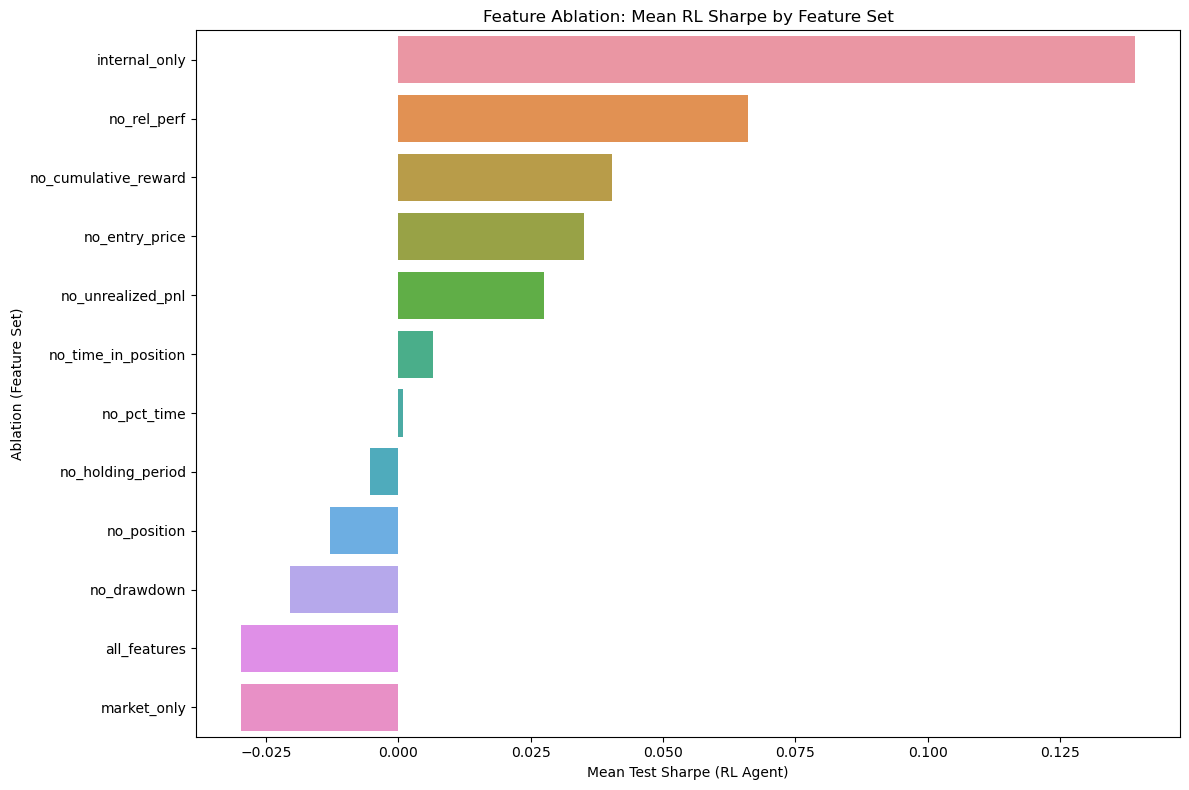


### Feature Ablation Summary Table:
| ablation             |   mean_sharpe_rl |   mean_sharpe_random |   t_pvalue |   u_pvalue | RL>Random   |
|:---------------------|-----------------:|---------------------:|-----------:|-----------:|:------------|
| internal_only        |          0.139   |             -0.00489 |     0.0283 |     0.0117 | True        |
| no_rel_perf          |          0.0661  |             -0.0432  |     0.0498 |     0.0268 | True        |
| no_cumulative_reward |          0.0403  |             -0.0292  |     0.21   |     0.0927 | True        |
| no_entry_price       |          0.035   |             -0.0168  |     0.342  |     0.213  | True        |
| no_unrealized_pnl    |          0.0275  |              0.0922  |     0.328  |     0.864  | False       |
| no_time_in_position  |          0.00657 |              0.0529  |     0.426  |     0.828  | False       |
| no_pct_time          |          0.00082 |             -0.0647  |     0.204  |     0.236  | True        |


In [2]:
import jupyter 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from src.utils.system import boot
from src.data.feature_pipeline import load_base_dataframe
from stable_baselines3 import PPO
from src.env.base_trading_env import (
    CumulativeTradingEnv,
)
boot()

# === 1. Feature sets ===
MARKET_FEATURES = [
    "day_of_month", "day_of_week", "order_flow", "candle_body",
    "upper_shadow", "lower_shadow", "price_change", "candle_change",
    "order_flow_change", "overnight_price_change", "volume_change",
    "vwap_change", "trade_count_change", "return_1d", "vix_norm", "market_return_1d"
]
INTERNAL_FEATURES = [
    "position", "holding_period", "cumulative_reward", "pct_time",
    "drawdown", "rel_perf", "unrealized_pnl", "entry_price", "time_in_position"
]

ablation_variants = [
    ("all_features", MARKET_FEATURES, INTERNAL_FEATURES),
    ("market_only", MARKET_FEATURES, []),
    ("internal_only", [], INTERNAL_FEATURES),
]
for f in INTERNAL_FEATURES:
    ablation_variants.append((
        f"no_{f}",
        MARKET_FEATURES,
        [i for i in INTERNAL_FEATURES if i != f]
    ))

# === 2. Experiment config ===
EXPERIMENT_NAME = "walkforward_ablation_base_env_internal_features"
EXCLUDED_TICKERS = ['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV']
TOTAL_TIMESTEPS = 20000
EPISODE_LENGTH = 50
TOTAL_TRAIN_EPISODES = int(TOTAL_TIMESTEPS/EPISODE_LENGTH)+1
TOTAL_TEST_EPISODES = 5
SEED = 314

walk_forward_splits = [
    ("2023-01-01", "2023-07-01", "2023-09-01", "2023-12-01"),
    ("2024-01-01", "2024-07-01", "2024-09-01", "2024-12-01"),
]

CONFIG = dict(
    total_train_episodes=TOTAL_TRAIN_EPISODES,
    total_test_episodes=TOTAL_TEST_EPISODES,
    episode_length=EPISODE_LENGTH,
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS,
    agent="PPO"
)

# === 3. Load Data ===
ohlcv_df = load_base_dataframe()

# === 4. Walk-forward evaluation function ===
def evaluate_feature_set(feature_cols, internal_features, config, walk_forward_splits,
                        RL_ENV_CLASS, ohlcv_df, EXCLUDED_TICKERS,
                        EPISODE_LENGTH, TOTAL_TRAIN_EPISODES, TOTAL_TEST_EPISODES, SEED):
    all_rows = []
    for split_idx, (train_start, train_end, test_start, test_end) in enumerate(walk_forward_splits):
        # Data splits
        df_train = ohlcv_df[(ohlcv_df['date'] >= train_start) & (ohlcv_df['date'] < train_end) & ~ohlcv_df['symbol'].isin(EXCLUDED_TICKERS)].reset_index(drop=True)
        df_test = ohlcv_df[(ohlcv_df['date'] >= test_start) & (ohlcv_df['date'] < test_end) & ~ohlcv_df['symbol'].isin(EXCLUDED_TICKERS)].reset_index(drop=True)

        def generate_episode_sequences(df, episode_length, n_episodes, excluded_tickers, seed=314):
            rng = np.random.default_rng(seed)
            eligible_tickers = [t for t in df['symbol'].unique() if t not in excluded_tickers]
            sequences = []
            for _ in range(n_episodes):
                ticker = rng.choice(eligible_tickers)
                stock_df = df[df['symbol'] == ticker]
                max_start = len(stock_df) - episode_length - 1
                if max_start < 1: continue
                start_idx = rng.integers(0, max_start)
                sequences.append((ticker, int(start_idx)))
            return sequences

        split_seed = int(pd.Timestamp(test_start).timestamp())
        train_seq = generate_episode_sequences(df_train, EPISODE_LENGTH, TOTAL_TRAIN_EPISODES, EXCLUDED_TICKERS, seed=split_seed)
        test_seq = generate_episode_sequences(df_test, EPISODE_LENGTH, TOTAL_TEST_EPISODES, EXCLUDED_TICKERS, seed=split_seed + 1)

        # RL Agent Training (PPO) -- instantiate env with current features
        train_env = RL_ENV_CLASS(df_train, feature_cols=feature_cols, internal_features=internal_features, episode_length=EPISODE_LENGTH, seed=SEED)
        train_env.set_episode_sequence(train_seq)
        test_env = RL_ENV_CLASS(df_test, feature_cols=feature_cols, internal_features=internal_features, episode_length=EPISODE_LENGTH, seed=SEED)
        test_env.set_episode_sequence(test_seq)

        agent = PPO("MlpPolicy", train_env, verbose=0, n_steps=EPISODE_LENGTH, seed=SEED, batch_size=EPISODE_LENGTH)
        agent.learn(total_timesteps=config['total_timesteps'])

        def evaluate_env(env, agent, n_episodes, agent_type):
            metrics = []
            for _ in range(n_episodes):
                obs, _ = env.reset()
                done = False
                while not done:
                    action, _ = agent.predict(obs, deterministic=True)
                    obs, reward, done, truncated, info = env.step(action)
                info = info.copy()
                info['agent'] = agent_type
                metrics.append(info)
            return metrics

        rl_metrics = evaluate_env(test_env, agent, len(test_seq), "RL")

        def evaluate_random(env, n_episodes):
            metrics = []
            for _ in range(n_episodes):
                obs, _ = env.reset()
                done = False
                while not done:
                    action = env.action_space.sample()
                    obs, reward, done, truncated, info = env.step(action)
                info = info.copy()
                info['agent'] = "Random"
                metrics.append(info)
            return metrics

        random_metrics = evaluate_random(test_env, len(test_seq))
        # Store all results
        for row in rl_metrics + random_metrics:
            row.update({"split": f"{test_start}--{test_end}"})
            all_rows.append(row)
    return pd.DataFrame(all_rows)

# === 5. Run ablation study ===
results_table = []
for ablation_name, feature_cols, internal_features in ablation_variants:
    print(f"\n==== Ablation: {ablation_name} ====")
    ablation_df = evaluate_feature_set(
        feature_cols=feature_cols,
        internal_features=internal_features,
        config=CONFIG,
        walk_forward_splits=walk_forward_splits,
        RL_ENV_CLASS=CumulativeTradingEnv,
        ohlcv_df=ohlcv_df,
        EXCLUDED_TICKERS=EXCLUDED_TICKERS,
        EPISODE_LENGTH=EPISODE_LENGTH,
        TOTAL_TRAIN_EPISODES=TOTAL_TRAIN_EPISODES,
        TOTAL_TEST_EPISODES=TOTAL_TEST_EPISODES,
        SEED=SEED,
    )
    ablation_df["ablation"] = ablation_name
    results_table.append(ablation_df)

# === 6. Combine all results
feature_ablation_df = pd.concat(results_table, ignore_index=True)

# === 7. Analyze and visualize ===
summary = []
for ablation, group in feature_ablation_df.groupby("ablation"):
    rl_sharpes = group.loc[group['agent']=='RL', 'episode_sharpe'].dropna()
    random_sharpes = group.loc[group['agent']=='Random', 'episode_sharpe'].dropna()
    mean_rl = rl_sharpes.mean() if len(rl_sharpes) > 0 else np.nan
    mean_random = random_sharpes.mean() if len(random_sharpes) > 0 else np.nan
    t_p = np.nan
    u_p = np.nan
    if len(rl_sharpes) > 1 and len(random_sharpes) > 1:
        t_stat, t_p = ttest_ind(rl_sharpes, random_sharpes, equal_var=False)
        u_stat, u_p = mannwhitneyu(rl_sharpes, random_sharpes, alternative='greater')
    summary.append({
        "ablation": ablation,
        "mean_sharpe_rl": mean_rl,
        "mean_sharpe_random": mean_random,
        "t_pvalue": t_p,
        "u_pvalue": u_p,
        "RL>Random": mean_rl > mean_random,
    })
summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by="mean_sharpe_rl", ascending=False)

# === 8. Visualization ===
plt.figure(figsize=(12,8))
sns.barplot(x='mean_sharpe_rl', y='ablation', data=summary_df)
plt.title("Feature Ablation: Mean RL Sharpe by Feature Set")
plt.xlabel("Mean Test Sharpe (RL Agent)")
plt.ylabel("Ablation (Feature Set)")
plt.tight_layout()
plt.show()

print("\n### Feature Ablation Summary Table:")
print(summary_df.to_markdown(index=False, floatfmt=".3g"))
